In [1]:
class_names = ['0', '1', '2',  '3', '4', 
          '5', '6', '7',  '8','9']

num_classes = len(class_names)

In [2]:
from os import path
from utils import tools

class Yolo_data(object):

    def __init__(self,
                 input_shape=(416, 416, 3),
                 class_names=[]):
        self.input_shape = input_shape
        self.grid_shape = input_shape[0]//32, input_shape[1]//32
        self.class_names = class_names
        self.class_num = len(class_names)
        self.file_names = None
        
    def read_file_to_dataset(
        self, img_path=None, label_path=None,
        label_format="labelimg",
        rescale=1/255,
        preprocessing=None,
        augmenter=None,
        aug_times=1,
        shuffle=True, seed=None,
        encoding="big5",
        thread_num=10):
        
        img_data, label_data, path_list = tools.read_file(
            img_path=img_path, 
            label_path=label_path,
            label_format=label_format,
            size=self.input_shape[:2], 
            grid_shape=self.grid_shape,
            class_names=self.class_names,
            rescale=rescale,
            preprocessing=preprocessing,
            augmenter=augmenter,
            aug_times=aug_times,
            shuffle=shuffle, seed=seed,
            encoding=encoding,
            thread_num=thread_num)
        self.file_names = path_list

        return img_data, label_data

    def vis_img(self, img, label_data,
                conf_threshold=0.5,
                show_conf=True,
                nms_mode=0,
                nms_threshold=0.5,
                nms_sigma=0.5,
                **kwargs):

        return tools.vis_img(
                             img, 
                             label_data, 
                             class_names=self.class_names,
                             conf_threshold=conf_threshold,
                             show_conf=show_conf,
                             nms_mode=nms_mode,  
                             nms_threshold=nms_threshold,
                             nms_sigma=nms_sigma,
                             version=2,
                             **kwargs)

Notice! Repeat!: 000922.jpg 10 11
Notice! Repeat!: 000945.jpg 10 8
Notice! Repeat!: 000685.jpg 10 4
Notice! Repeat!: 000147.jpg 3 7
Notice! Repeat!: 000789.jpg 11 6
Notice! Repeat!: 000095.jpg 6 2
Notice! Repeat!: 000180.jpg 3 9


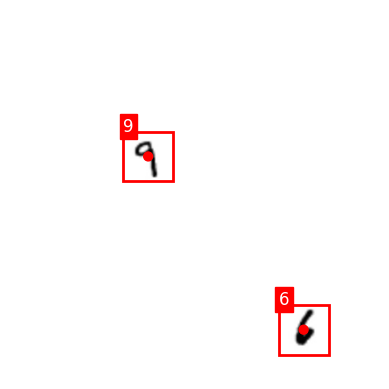

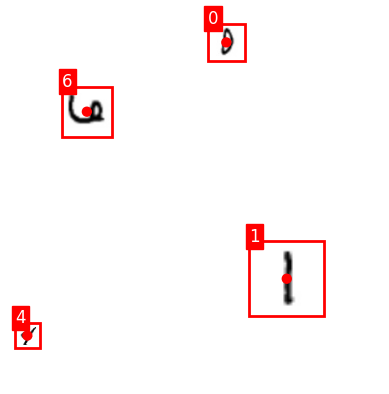

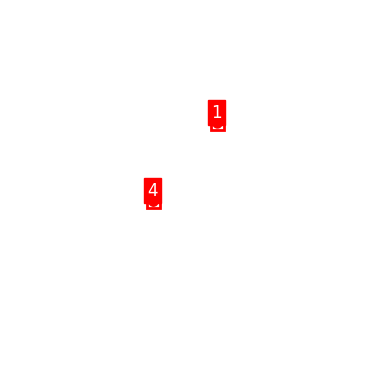

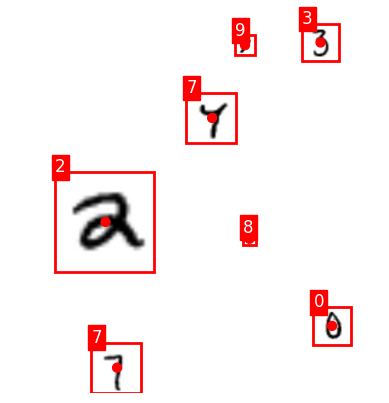

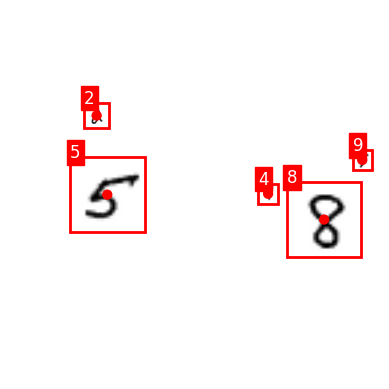

Notice! Repeat!: 000065.jpg 3 5
Notice! Repeat!: 000027.jpg 6 10
Notice! Repeat!: 000140.jpg 7 5


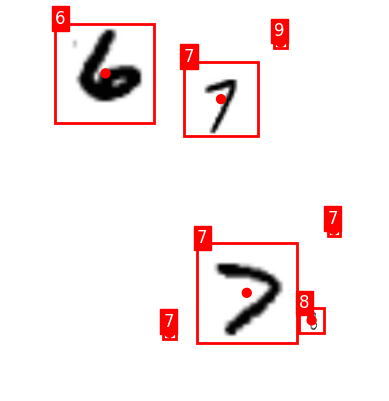

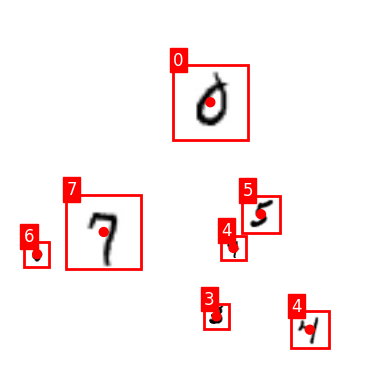

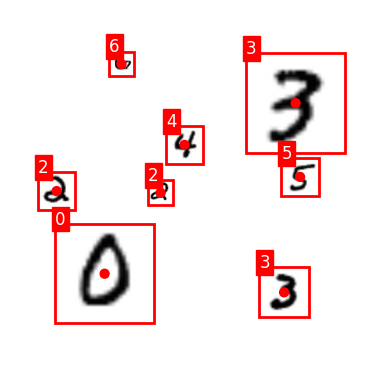

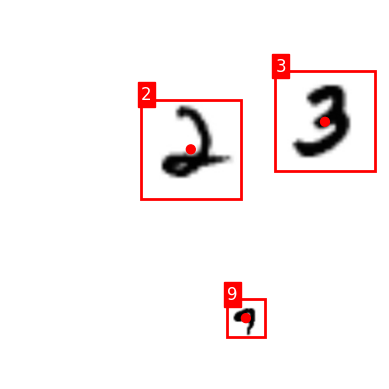

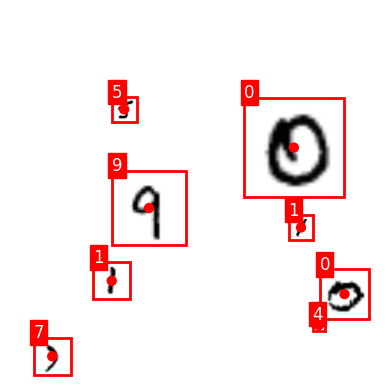

In [3]:
yolo_data = Yolo_data(class_names=class_names)

img_path   = "../01_1K_MNIST/mnist_train/"
label_path = "../01_1K_MNIST/xml_train/"

train_img, train_label = yolo_data.read_file_to_dataset(
    img_path, label_path,
    label_format="labelimg",
    thread_num=50,
    shuffle=False)

for i in range(5):
    yolo_data.vis_img(
        train_img[i], train_label[i],
        show_conf=False)

img_path   = "../01_1K_MNIST/mnist_val/"
label_path = "../01_1K_MNIST/xml_val/"

test_img, test_label = yolo_data.read_file_to_dataset(
    img_path, label_path,
    label_format="labelimg",
    thread_num=50,
    shuffle=False)

valid_img  = test_img
valid_label = test_label

for i in range(5):
    yolo_data.vis_img(
        valid_img[i], valid_label[i],
        show_conf=False)

In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, concatenate, LeakyReLU, BatchNormalization
import tensorflow as tf 
import numpy as np

n_epoch = 10

In [5]:
## Leaky Convolutional
def Conv2D_BN_Leaky(input_tensor, *args):
    output_tensor = Conv2D(*args, 
                           padding='same',
                           kernel_initializer='he_normal')(input_tensor)
    output_tensor = BatchNormalization()(output_tensor)
    output_tensor = LeakyReLU(alpha=0.1)(output_tensor)
    return output_tensor

In [6]:
## Backbone
def Backbone_darknet(input_tensor):
    conv1 = Conv2D_BN_Leaky(input_tensor, 32, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D_BN_Leaky(pool1, 64, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D_BN_Leaky(pool2, 128, 3)
    conv3 = Conv2D_BN_Leaky(conv3, 64, 1)
    conv3 = Conv2D_BN_Leaky(conv3, 128, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D_BN_Leaky(pool3, 256, 3)
    conv4 = Conv2D_BN_Leaky(conv4, 128, 1)
    conv4 = Conv2D_BN_Leaky(conv4, 256, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D_BN_Leaky(pool4, 512, 3)
    conv5 = Conv2D_BN_Leaky(conv5, 256, 1)
    conv5 = Conv2D_BN_Leaky(conv5, 512, 3)
    conv5 = Conv2D_BN_Leaky(conv5, 256, 1)
    conv5 = Conv2D_BN_Leaky(conv5, 512, 3)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    
    conv6 = Conv2D_BN_Leaky(pool5, 1024, 3)
    conv6 = Conv2D_BN_Leaky(conv6, 512, 1)
    conv6 = Conv2D_BN_Leaky(conv6, 1024, 3)
    conv6 = Conv2D_BN_Leaky(conv6, 512, 1)
    
    output_tensor = Conv2D_BN_Leaky(conv6, 1024, 3)
    
    return output_tensor

In [7]:
## Yolo Neck
def yolo_neck(input_shape=(416, 416, 3),
              backbone="darknet",
              pretrained_darknet=None):
    inputs = Input(input_shape)
    darknet = Model(inputs, Backbone_darknet(inputs))
    if pretrained_darknet is not None:
        darknet.set_weights(pretrained_darknet.get_weights())
    
    passthrough = darknet.layers[43].output
    conv = Conv2D_BN_Leaky(darknet.output, 1024, 3)
    conv = Conv2D_BN_Leaky(conv, 1024, 3)

    passthrough = Conv2D_BN_Leaky(passthrough, 512, 3)
    passthrough = tf.nn.space_to_depth(passthrough, 2)

    merge = concatenate([passthrough, conv], axis=-1)

    outputs = Conv2D_BN_Leaky(merge, 1024, 3)

    model = Model(inputs, outputs)
    
    return model

In [8]:
## Head
def yolo_head(model_body, class_num=10, 
              anchors=[(0.04405615, 0.05210654),
                       (0.14418923, 0.15865615),
                       (0.25680231, 0.42110308),
                       (0.60637077, 0.27136769),
                       (0.75157846, 0.70525231)]):
    anchors = np.array(anchors)
    inputs = model_body.input
    output = model_body.output
    output_list = []
    for box in anchors:
        xy_output = Conv2D(2, 1,
                           padding='same',
                           activation='sigmoid',
                           kernel_initializer='he_normal')(output)
        wh_output = Conv2D(2, 1,
                           padding='same',
                           activation='exponential',
                           kernel_initializer='he_normal')(output)
        wh_output = wh_output * box
        c_output = Conv2D(1, 1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal')(output)
        p_output = Conv2D(class_num, 1,
                          padding = 'same',
                          activation='softmax',
                          kernel_initializer='he_normal')(output)
        output_list += [xy_output,
                        wh_output,
                        c_output,
                        p_output]

    outputs = concatenate(output_list, axis=-1)
    
    model = Model(inputs, outputs)

    return model

In [9]:
epsilon = 1e-07
## IoU
def cal_iou(xywh_true, xywh_pred, grid_shape):
    grid_shape = np.array(grid_shape[::-1])
    xy_true = xywh_true[..., 0:2]/grid_shape # N*S*S*1*2
    wh_true = xywh_true[..., 2:4]

    xy_pred = xywh_pred[..., 0:2]/grid_shape # N*S*S*B*2
    wh_pred = xywh_pred[..., 2:4]
    
    half_xy_true = wh_true / 2.
    mins_true    = xy_true - half_xy_true
    maxes_true   = xy_true + half_xy_true

    half_xy_pred = wh_pred / 2.
    mins_pred    = xy_pred - half_xy_pred
    maxes_pred   = xy_pred + half_xy_pred       
    
    intersect_mins  = tf.maximum(mins_pred,  mins_true)
    intersect_maxes = tf.minimum(maxes_pred, maxes_true)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = wh_true[..., 0] * wh_true[..., 1]
    pred_areas = wh_pred[..., 0] * wh_pred[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = (intersect_areas + epsilon)/(union_areas + epsilon)
    
    return iou_scores

In [10]:
## Yolo Loss Function
def wrap_yolo_loss(grid_shape,
                   bbox_num,
                   class_num,
                   anchors,
                   binary_weight=1,
                   loss_weight=[1, 1, 1, 1],
                   ignore_thresh=.6,
                   ):
    def yolo_loss(y_true, y_pred):
        panchors = tf.reshape(anchors, (1, 1, 1, bbox_num, 2))

        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*(5+C)
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*(5+C)

        xywh_true = y_true[..., :4] # N*S*S*1*4
        xywh_pred = y_pred[..., :4] # N*S*S*B*4

        iou_scores = cal_iou(xywh_true, xywh_pred, grid_shape) # N*S*S*B
        
        response_mask = tf.one_hot(tf.argmax(iou_scores, axis=-1),
                                   depth=bbox_num,
                                   dtype=xywh_true.dtype) # N*S*S*B

        has_obj_mask = y_true[..., 4]*response_mask # N*S*S*B
        has_obj_mask_exp = tf.expand_dims(has_obj_mask, axis=-1) # N*S*S*B*1

        no_obj_mask = tf.cast(
            iou_scores < ignore_thresh,
            iou_scores.dtype) # N*S*S*B
        no_obj_mask = (1 - has_obj_mask)*no_obj_mask # N*S*S*B

        xy_true = y_true[..., 0:2] # N*S*S*1*2
        xy_pred = y_pred[..., 0:2] # N*S*S*B*2

        wh_true = tf.maximum(y_true[..., 2:4]/panchors, epsilon) # N*S*S*1*2
        wh_pred = y_pred[..., 2:4]/panchors
        
        wh_true = tf.math.log(wh_true) # N*S*S*B*2
        wh_pred = tf.math.log(wh_pred) # N*S*S*B*2

        c_pred = y_pred[..., 4] # N*S*S*B

        box_loss_scale = 2 - y_true[..., 2:3]*y_true[..., 3:4] # N*S*S*1*1

        xy_loss = tf.reduce_sum(
            tf.reduce_mean(
                has_obj_mask_exp # N*S*S*B*1
                *box_loss_scale # N*S*S*1*1
                *tf.square(xy_true - xy_pred), # N*S*S*B*2
                axis=0))

        wh_loss = tf.reduce_sum(
            tf.reduce_mean(
                has_obj_mask_exp # N*S*S*B*1
                *box_loss_scale # N*S*S*1*1
                *tf.square(wh_true - wh_pred), # N*S*S*B*2
                axis=0))

        has_obj_c_loss = tf.reduce_sum(
                tf.reduce_mean(
                has_obj_mask # N*S*S*B
                *(tf.square(1 - c_pred)), # N*S*S*B
                axis=0))

        no_obj_c_loss = tf.reduce_sum(
                tf.reduce_mean(
                no_obj_mask # N*S*S*1
                *(tf.square(0 - c_pred)), # N*S*S*B
                axis=0))
        
        c_loss = has_obj_c_loss + binary_weight*no_obj_c_loss

        p_true = y_true[..., -class_num:] # N*S*S*1*C
        p_pred = y_pred[..., -class_num:] # N*S*S*B*C
        p_pred = tf.clip_by_value(p_pred, epsilon, 1 - epsilon)
        p_loss = -tf.reduce_sum(
            tf.reduce_mean(
                has_obj_mask_exp # N*S*S*B*1
                *(p_true*tf.math.log(p_pred)
                + (1 - p_true)*tf.math.log(1 - p_pred)), # N*S*S*B*C
                axis=0))

        loss = (loss_weight[0]*xy_loss
                + loss_weight[1]*wh_loss
                + loss_weight[2]*c_loss
                + loss_weight[3]*p_loss)

        return loss

    return yolo_loss

In [11]:
## Object Accuracy
from keras.metrics import binary_accuracy

def wrap_obj_acc(grid_shape, bbox_num, class_num):
    def obj_acc(y_true, y_pred):
        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*5+C
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*5+C
        
        c_true = y_true[..., 4] # N*S*S*1
        c_pred = tf.reduce_max(y_pred[..., 4], # N*S*S*B
                               axis=-1,
                               keepdims=True) # N*S*S*1

        bi_acc = binary_accuracy(c_true, c_pred)

        return bi_acc
    return obj_acc

In [12]:
## Mean IoU
def wrap_mean_iou(grid_shape, bbox_num, class_num):
    def mean_iou(y_true, y_pred):
        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*5+C
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*5+C

        has_obj_mask = y_true[..., 4] # N*S*S*1
        
        xywh_true = y_true[..., :4] # N*S*S*1*4
        xywh_pred = y_pred[..., :4] # N*S*S*B*4

        iou_scores = cal_iou(xywh_true, xywh_pred, grid_shape) # N*S*S*B
        iou_scores = tf.reduce_max(iou_scores, axis=-1, keepdims=True) # N*S*S*1
        iou_scores = iou_scores*has_obj_mask # N*S*S*B

        num_p = tf.reduce_sum(has_obj_mask)

        return tf.reduce_sum(iou_scores)/(num_p + epsilon)
    return mean_iou

In [13]:
## Class accuracy
def wrap_class_acc(grid_shape, bbox_num, class_num):
    def class_acc(y_true, y_pred):
        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*5+C
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*5+C

        has_obj_mask = y_true[..., 4] # N*S*S*1

        pi_true = tf.argmax(y_true[..., -class_num:], # N*S*S*1*C
                            axis=-1) # N*S*S*1
        pi_pred = tf.argmax(y_pred[..., -class_num:], # N*S*S*B*C
                            axis=-1) # N*S*S*B
        
        equal_mask = tf.cast(pi_true == pi_pred,
                             dtype=y_true.dtype) # N*S*S*B
        equal_mask = equal_mask*has_obj_mask # N*S*S*B

        num_p = tf.reduce_sum(has_obj_mask)*bbox_num

        return tf.reduce_sum(equal_mask)/(num_p + epsilon)
    return class_acc

In [14]:
## Build Class for Model, Loss, Metrics
class Yolo(object):

    def __init__(self,
                 input_shape=(416, 416, 3),
                 class_names=[]):
        self.input_shape = input_shape
        self.grid_shape = input_shape[0]//32, input_shape[1]//32
        self.bbox_num = 5
        self.class_names = class_names
        self.class_num = len(class_names)
        self.anchors = None
        self.model = None
        self.file_names = None
        
    '''
    Model Create
    '''
    def create_model(self,
                     anchors=[[0.75157846, 0.70525231],
                              [0.60637077, 0.27136769],
                              [0.25680231, 0.42110308],
                              [0.14418923, 0.15865615],
                              [0.04405615, 0.05210654]],
                     backbone="darknet",
                     pretrained_weights=None,
                     pretrained_darknet=None):
        
        model_body = yolo_neck(self.input_shape,
                               backbone,
                               pretrained_darknet)

        self.model = yolo_head(model_body,
                               self.class_num,
                               anchors)
         
        if pretrained_weights is not None:
            self.model.load_weights(pretrained_weights)
        self.anchors = anchors
        self.grid_shape = self.model.output.shape[1:3]
        self.bbox_num = len(anchors)
    '''
    Loss Create
    '''
    def loss(self,
            binary_weight=1,
            loss_weight=[1, 1, 5, 1],
            ignore_thresh=0.6):
    
        if isinstance(loss_weight, dict):
            loss_weight_list = []
            loss_weight_list.append(loss_weight["xy"])
            loss_weight_list.append(loss_weight["wh"])
            loss_weight_list.append(loss_weight["conf"])
            loss_weight_list.append(loss_weight["prob"])
            loss_weight = loss_weight_list
        
        return wrap_yolo_loss(
            grid_shape=self.grid_shape,
            bbox_num=self.bbox_num, 
            class_num=self.class_num,
            anchors=self.anchors,
            binary_weight=binary_weight,
            loss_weight=loss_weight,
            ignore_thresh=ignore_thresh,
            )
    '''
    Metrics Create
    '''
    def metrics(self, type="obj_acc"):
        
        metrics_list = []     
        if "obj" in type:
            metrics_list.append(
                wrap_obj_acc(
                    self.grid_shape, 
                    self.bbox_num, 
                    self.class_num))
        if "iou" in type:
            metrics_list.append(
                wrap_mean_iou(
                    self.grid_shape, 
                    self.bbox_num, 
                    self.class_num))
        if "class" in type:
            metrics_list.append(
                wrap_class_acc(
                    self.grid_shape, 
                    self.bbox_num, 
                    self.class_num))
        
        return metrics_list

epoch  1: loss = 0.5901
epoch  2: loss = 0.2392
epoch  3: loss = 0.0673
epoch  4: loss = 0.0000


array([[0.26923078, 0.26923078],
       [0.20192307, 0.20192307],
       [0.11768076, 0.11768076],
       [0.06087702, 0.06087702],
       [0.03365385, 0.03365385]], dtype=float32)

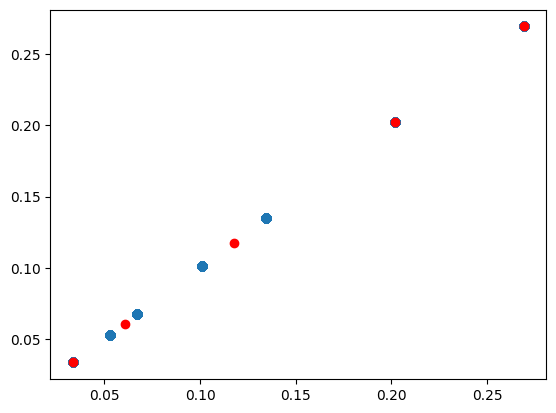

In [15]:
## Get anchor boxes
from utils.kmeans import kmeans, iou_dist, euclidean_dist
import numpy as np

all_boxes = train_label[train_label[..., 4] == 1][..., 2:4]
anchors = kmeans(
    all_boxes,
    n_cluster=5,
    dist_func=iou_dist,
    stop_dist=0.00001)

anchors = np.sort(anchors, axis=0)[::-1]
display(anchors)

import matplotlib.pyplot as plt

plt.scatter(all_boxes[..., 0], all_boxes[..., 1])
plt.scatter(anchors[..., 0],
            anchors[..., 1],
            c="red")
plt.show()


In [16]:
## Build NN Model from Class
yolo = Yolo(class_names=class_names)

# anchors = [[0.33626917, 0.40490368],
#            [0.19854431, 0.24941406],
#            [0.16811553, 0.21535812],
#            [0.1445463 , 0.18271673],
#            [0.06220668, 0.08011432]]
anchors = [[0.26923078, 0.26923078],
            [0.20192307, 0.20192307],
            [0.11768076, 0.11768076],
            [0.0673077,  0.0673077 ],
            [0.04344729, 0.04344729]]

yolo.create_model(anchors=anchors)
yolo.model.summary()




Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 416, 416, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 416, 416, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 416, 416, 32)         0         ['batch_normalization[

In [17]:
## Define Optimizer
from keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-4)

In [18]:
## Calback Function
## Learning Rate Scheduling
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
    if epoch <= 20:
        return lr
    elif epoch <= 70:
        return 3e-5
    else:
        return 1e-5

callback = LearningRateScheduler(scheduler)

In [19]:
## Callback Function
## Loss Function from YOLO class
from utils.tools import get_class_weight

binary_weight = get_class_weight(
    train_label[..., 4:5],
    method='binary'
    )
print(binary_weight)

loss_weight = {
    "xy":1,
    "wh":1,
    "conf":5,
    "prob":1
    }

loss_fn = yolo.loss(
    binary_weight=binary_weight,
    loss_weight=loss_weight
    )

[0.0369116]


In [20]:
## Build Metrics from YOLO Class
metrics = yolo.metrics("obj+iou+class")

In [21]:
## Model Compilation
yolo.model.compile(
    optimizer = optimizer,
    #optimizer=SGD(learning_rate=1e-10, momentum=0.9, decay=5e-4),
    loss = loss_fn,
    metrics = metrics
    )

In [22]:
## Model Training and Validation
import time
start_time = time.time()
train_history = yolo.model.fit(
    train_img,
    train_label,
    epochs = n_epoch,
    batch_size=5,
    verbose=1,
    validation_data=(valid_img, valid_label),
    callbacks=[callback]
    )

Epoch 1/10


200/200 [==============================] - 1097s 5s/step - loss: 43.9422 - obj_acc: 0.9066 - mean_iou: 0.4815 - class_acc: 0.1297 - val_loss: 54.6911 - val_obj_acc: 0.9719 - val_mean_iou: 0.3636 - val_class_acc: 0.1069 - lr: 1.0000e-04
Epoch 2/10
200/200 [==============================] - 1098s 5s/step - loss: 24.7255 - obj_acc: 0.9736 - mean_iou: 0.6362 - class_acc: 0.1951 - val_loss: 25.4531 - val_obj_acc: 0.9813 - val_mean_iou: 0.6203 - val_class_acc: 0.1478 - lr: 1.0000e-04
Epoch 3/10
200/200 [==============================] - 1078s 5s/step - loss: 22.0836 - obj_acc: 0.9788 - mean_iou: 0.6487 - class_acc: 0.2798 - val_loss: 20.9454 - val_obj_acc: 0.9832 - val_mean_iou: 0.6658 - val_class_acc: 0.2669 - lr: 1.0000e-04
Epoch 4/10
200/200 [==============================] - 1091s 5s/step - loss: 19.5199 - obj_acc: 0.9814 - mean_iou: 0.6413 - class_acc: 0.3822 - val_loss: 19.7732 - val_obj_acc: 0.9871 - val_mean_iou: 0.6020 - val_class_acc: 0.3725 - lr: 1.0000e-04
Epoch 5/10

In [23]:
yolo.model.save_weights('./weight_yolov2_1.h5')

1/1 [==============================] - 1s 1s/step


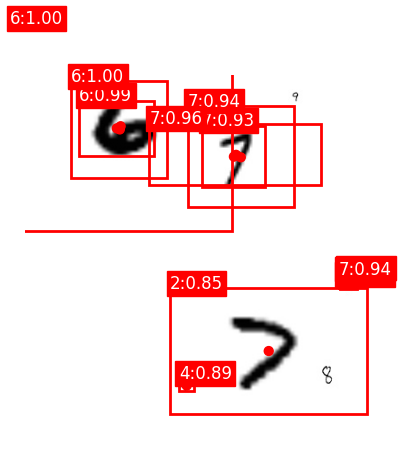

In [44]:
image = np.expand_dims(test_img[0], axis=0)
prediction = yolo.model.predict(image)

for i in range(len(image)):
    yolo_data.vis_img(
        image[i],
        prediction[i],
        conf_threshold=0.8,
        nms_mode=0,
        )

In [17]:
yolo.model.load_weights('./weight_yolov2_1.h5')

1/1 [==============================] - 1s 631ms/step


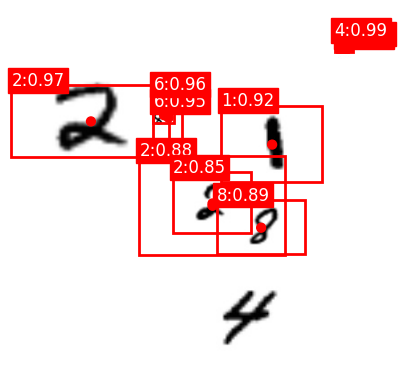

In [29]:
image = np.expand_dims(test_img[64], axis=0)
prediction = yolo.model.predict(image)

for i in range(len(image)):
    yolo_data.vis_img(
        image[i],
        prediction[i],
        conf_threshold=0.8,
        nms_mode=1,
        )